In [158]:
import numpy as np
from fourier import compute_fourier_coeff
from signal_functions import truncated_sine_series
from fourier import compute_fourier_coeff
from kernels import complex_exponential_kernel, cosine_kernel, dirichlet_kernel_shifted
from inference_utils import  run_inference_time_localized
from plotting import  plot_true_vs_approximation

import matplotlib.pyplot as plt

In [159]:

#TODO
# lambda has to be very small (* 1e-4) to get a good approx, why?


In [160]:
#CHOOSE number of input functions
num_samples = 250

grid_size = 2**11 # grid points

t_left = 0 
t_right = 1

time_span = t_right - t_left

time_array = np.linspace(t_left,t_right,grid_size)


In [161]:
#parameter for target signal
target_decay_rate = 1.1 # decay rate of the target signal  #1.1
noise = .01 # noise level

In [162]:
# Ground truth function and observation  noise         
# y_i = x_i * target + noise, where x_i is the input signal

sum_terms_target = 22  # index  of truncation of the fourier series
target = truncated_sine_series(
    input_points=time_array, decay_rate=target_decay_rate, num_terms=sum_terms_target
)

##fourier coefficients of w_true
target_fourier_coeff = compute_fourier_coeff(
    target, time_span
)  # normalized by the number of grid points


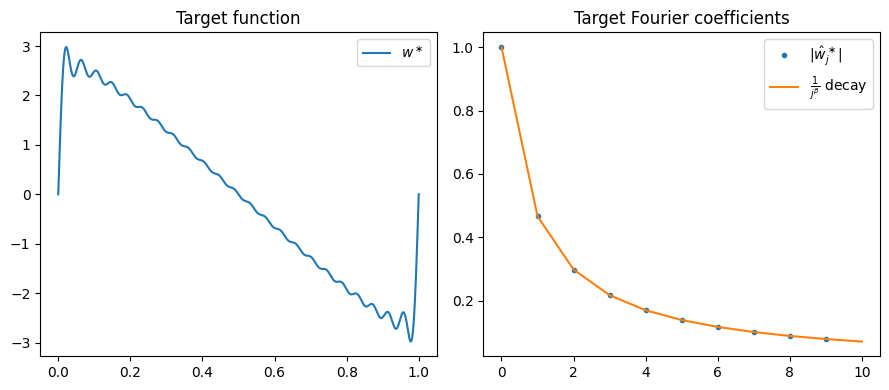

In [163]:
# Visualize the target function and its fourier coefficients decay

#plot the true function and its fourier coefficients in two subplots
fig,(ax1, ax2)  = plt.subplots(1,2,figsize=(9, 4))
ax1.plot(time_array,target, label = r'$w^\ast$')
ax1.set_title('Target function')
ax1.legend()

plot_till = sum_terms_target //2

ax2.plot(np.abs(target_fourier_coeff)[1:plot_till], '.', label=r'$|\hat{w}^\ast_j|$')
# Create auxiliary vector for decay comparison
j_values = np.arange(1, target_fourier_coeff.size + 1, dtype=float)

ax2.plot(j_values[:plot_till]**(-target_decay_rate), label=r'$\frac{1}{j^\beta}$ decay')
ax2.set_title('Target Fourier coefficients')
ax2.legend()
plt.tight_layout()

In [164]:
# the kernel

# complex exponential kernel
kernel_decay_rate =  1.01 # decay rate of the  complex exponential kernel   #1.01
sum_terms_kernel = sum_terms_target
evaluated_kernel = complex_exponential_kernel(time_array, kernel_decay_rate, sum_terms_kernel)
kernel_coeff = compute_fourier_coeff(evaluated_kernel, time_span)
kernel_coeff_abs = np.abs(kernel_coeff)   #TODO why do you need to take abs?


#dirichlet kernel
# order_dirichlet_ker = sum_terms_target
# evaluated_kernel = dirichlet_kernel_shifted(time_array, order_dirichlet_ker, L=1/2)
# kernel_decay_rate = 0

# kernel_coeff = compute_fourier_coeff(evaluated_kernel, time_span)
# kernel_coeff_abs = np.abs(kernel_coeff)   #TODO why do you need to take abs?
# kernel_coeff = np.ones(grid_size)


/home/emilia/.local/miniconda3/envs/conv/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/emilia/.local/miniconda3/envs/conv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


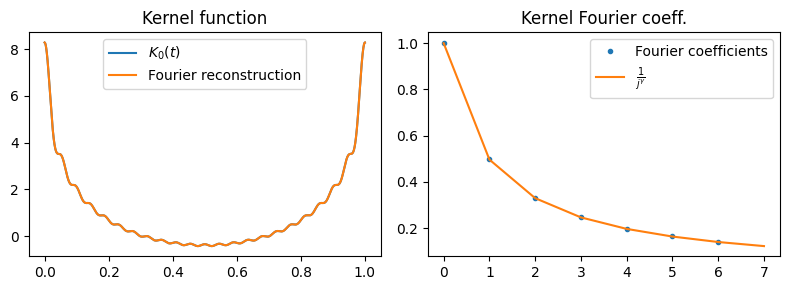

In [165]:
# visualize the kernel's fourier coefficients decay  (for the complex exponential kernel)

fig,(ax1, ax2)  = plt.subplots(1,2,figsize=(8, 3))
ax1.plot(time_array, evaluated_kernel, label=r'$K_0(t)$')
ax1.set_title('Kernel function')
ax1.plot(time_array, np.fft.ifft(kernel_coeff*grid_size), label='Fourier reconstruction')
ax1.legend()

plot_till = sum_terms_kernel //3
ax2.plot(kernel_coeff_abs[1:plot_till+1], '.', label='Fourier coefficients')
aux_vec=np.arange(1,kernel_coeff.size+1, dtype=float)
ax2.plot(aux_vec[:plot_till+1]**(-kernel_decay_rate), label=r'$\frac{1}{j^\gamma}$')
ax2.set_title('Kernel Fourier coeff.')
ax2.legend()
plt.tight_layout()


In [166]:
# time-loc signals
loc_parameter = 0.0001  # choose a small delta

if kernel_decay_rate == 0:
    alpha_sup = 1
else:
    alpha_sup = (2*target_decay_rate -1 - kernel_decay_rate) / 2*kernel_decay_rate

In [167]:
alpha = .3*alpha_sup
# alpha = .5
b = kernel_decay_rate

In [168]:
print(alpha)
print(num_samples ** (-1 / (2 * alpha + 1 + 1/b)))

0.028785000000000026
0.06744373185832371


__Source conditions__:

$$ 
\sum_{l \in \mathbb{Z}} \frac{{|\hat{w}^\ast_l|^2 } }{\hat{k}_l( \hat{k}_l \mathbb{E}[|\hat{X}_l|^2])^{2\alpha}}  < + \infty
$$

with  $ \gamma_l :=  \hat{k}_l\, \mathbb{E}[|\hat{X}_l|^2] $ eigenvalues of covariance operator.


__Time localized signals__:  
    $$ X(t) = \frac{1}{2\delta}{1}_{[0,2 \delta]} (t-T) $$
    with $T$ random variable on $G$ and $\delta>0$.
    We choose $T \sim \mathcal{N}(\mu,\sigma^2)$.

Eigenvalues of the covariance operator: $\gamma_j= \hat{k}_j  \text{sinc}^2({ 2 \pi \delta l } ) .$
    

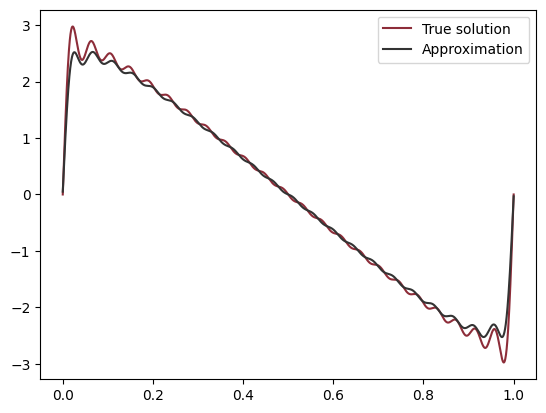

In [169]:
# run inference for time-localized signals
prediction_fourier, prediction = run_inference_time_localized(
    num_samples= num_samples,
    time_array=time_array,
    time_span=time_span,
    kernel_coeff=kernel_coeff,
    target_fourier_coeff=target_fourier_coeff,
    noise=noise,
    alpha=alpha,
    b=b,
    loc_parameter=loc_parameter,
)
plot_true_vs_approximation(time_array, target, prediction)


In [ ]:
# np.save('prediction_time-loc.npy', prediction)

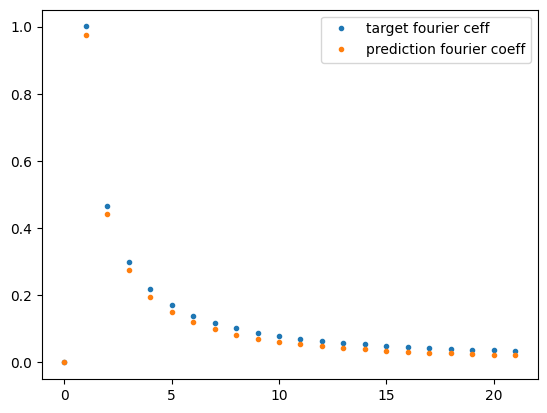

In [171]:
plt.plot(np.abs(target_fourier_coeff[:sum_terms_target]), '.', label='target fourier ceff')
plt.plot(np.abs(prediction_fourier[:sum_terms_target]), '.', label='prediction fourier coeff')
plt.legend()

In [172]:
# from inference_utils import run_inference_error_time_localized
# error_squared_sampmean_time_loc, error_squared_sampstd_time_loc, error_squared_logmean_time_loc, error_squared_logstd_time_loc = run_inference_error_time_localized(
#     num_samples=num_samples,
#     num_experiments= 3,
#     time_array=time_array,
#     time_span=time_span,
#     kernel_coeff= kernel_coeff,
#     target_fourier_coeff=target_fourier_coeff,
#     noise=noise,
#     alpha=alpha,
#     b=b,
#     series_truncation=sum_terms_target,
#     loc_parameter=loc_parameter
# )


In [173]:
# fig, ax = plt.subplots(1,  )

# index = np.arange(1,error_squared_sampmean_time_loc.size+1)


# ax.plot(index, error_squared_sampmean_time_loc, '-o', markersize=1.7, color='r', alpha =1., label=r'time-loc')
# ax.errorbar(index, error_squared_sampmean_time_loc, yerr =error_squared_sampstd_time_loc, color='r', fmt='o', alpha=.4, capsize=2.5,ms=1)



# # #concatenate two arrays
# # xticks = np.concatenate((index[0:1],index[9::100]))
# # ax.set_xticks(xticks)
# ax.set_ylabel(r'Error  $ \parallel \widetilde{w}_\lambda - w^* \parallel_{\mathcal{H}} ^2$')

# # ## alpha-rate 
# # C =1
# # ax.plot(index, C / (index **(2*alpha/(2*alpha+1 + 1/b))) , color = 'r', lw=1.0,alpha=0.5)
# # 
# ax.set_xscale('log')
# ax.set_yscale('log')

# ax.legend()
# # # plt.savefig('Time-loc-inpu